In [2]:
import torch
import torch.nn as nn
import pandas as pd
from price_predictor import Model, BookDataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

c:\Users\drobi\OneDrive\Documents\GitHub\bookmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Prepare Data

In [4]:
BATCH_SIZE=4
df = pd.read_csv('test.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
price_model = Model().to(device)
price_model.load_state_dict(torch.load(f="model.pt"))

convert_to_tensor = lambda column: [[float(x) for x in list.strip(')(][').split(", ")] for list in df[column].tolist()]
train_dataset, test_dataset = BookDataset.train_test_split(convert_to_tensor('details'), convert_to_tensor('prices'), convert_to_tensor('conditions'), df['targets'].tolist(), device=device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
model = Model().to(device)

### Test First Batch

In [6]:
details, prices, conditions, targets = next(iter(test_dataloader))
preds = model(details, prices, conditions)
print("Expected:", targets)
print("Actual:", preds)

Expected: tensor([19.3200,  3.2100, 14.0700, 79.5400], device='cuda:0')
Actual: tensor([ -740646.0625,   -62330.6602,    -6561.4463, -1332581.6250],
       device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([4])


## Training Loop

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [8]:
epochs=1000
train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    avg_train_loss = 0

    for details, prices, conditions, targets in train_dataloader:
        pred = model(details, prices, conditions)

        loss = loss_fn(pred, targets)
        
        avg_train_loss += loss.detach().cpu().numpy()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss /= len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    # Testing
    model.eval()
    avg_test_loss = 0

    with torch.inference_mode():
        for details, prices, conditions, targets in test_dataloader:
            pred = model(details, prices, conditions)

            loss = loss_fn(pred, targets)

            avg_test_loss += loss.detach().cpu().numpy()

        avg_test_loss /= len(test_dataloader)
        test_loss_values.append(avg_test_loss)

100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


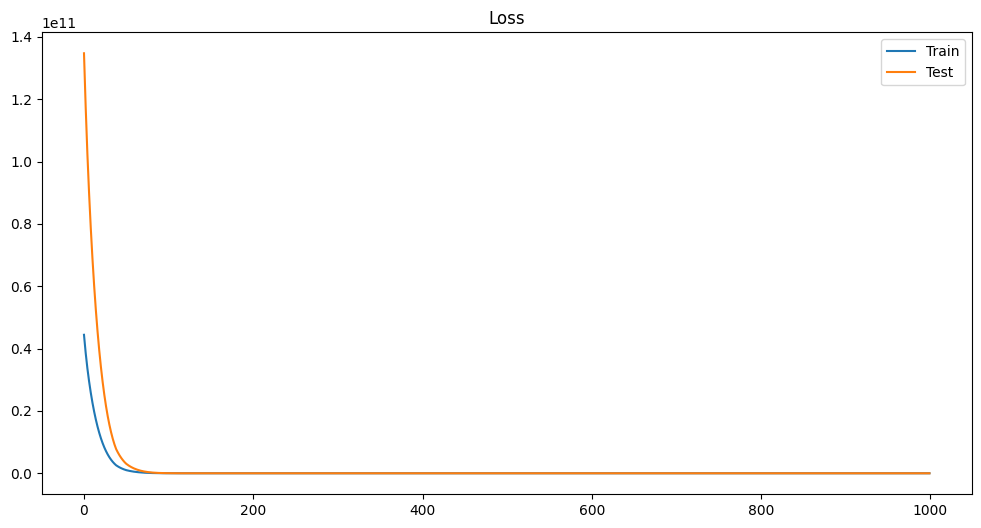

In [9]:
plt.figure(figsize=(12, 6))
plt.title("Loss")
plt.plot(range(epochs), train_loss_values, label="Train")
plt.plot(range(epochs), test_loss_values, label="Test")
plt.legend();

In [10]:
details, prices, conditions, targets = next(iter(test_dataloader))
preds = model(details, prices, conditions)
print("Expected:", targets)
print("Actual:", preds)

Expected: tensor([19.3200,  3.2100, 14.0700, 79.5400], device='cuda:0')
Actual: tensor([30.4309,  3.4816,  6.6434, 92.5246], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
